# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [57]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task 

import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import io
import numpy as np
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage.color import rgb2gray

Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [58]:
def cont_str (inputimage) :
    
    image = inputimage
    max_im = image.max()
    min_im = image.min()
    
    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            image[i,j]=255*(image[i,j]-min_im)/( max_im-min_im)
    return image

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

C:\Users\natal\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


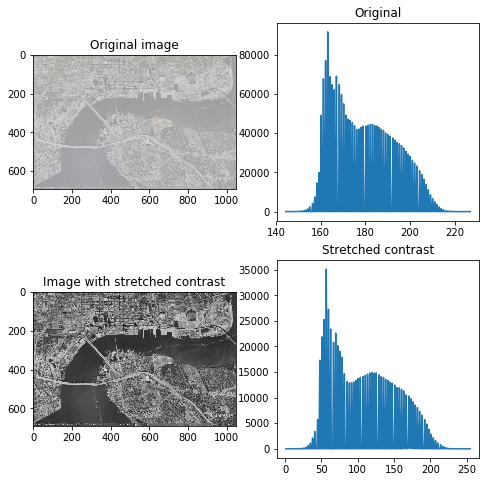

In [64]:
img_path = './images/satellite.jpg'
img_name = io.imread(img_path)

img_name_gray = rgb2gray (img_name)
img_name_ubyte = img_as_ubyte(img_name_gray)

fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img_name, cmap=cm.gray)
ax0.set_title('Original image')

bins, bins_c=np.histogram(img_name, 256)
ax1.plot(bins_c[1:], bins)
ax1.set_title('Original')

img_cont_str=cont_str(img_name_ubyte)
ax2.imshow(img_cont_str, cmap=cm.gray)
ax2.set_title('Image with stretched contrast')

bins, bins_c=np.histogram(img_cont_str, 256)
ax3.plot(bins_c[1:], bins)
ax3.set_title('Stretched contrast')

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [60]:
def hist_eq (image, min_int, max_int) :
    
    Hist, bins=np.histogram(image.flatten(), bins=max_int-min_int, normed=True)
    cdf=np.cumsum(Hist)
    Histcum=255*cdf/cdf[-1]
    image2=np.interp(image.flatten(), bins[:-1], Histcum)
    print(Histcum.size)
    return image2.reshape(image.shape), Histcum

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [61]:

img_path = './images/satellite.jpg'
img_name = io.imread(img_path)
img_name_gray = rgb2gray (img_name)
img_name_ubyte = img_as_ubyte(img_name_gray)
sat_eq, cdf_eq=hist_eq(img_name_ubyte, 0, 255)


255


C:\Users\natal\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


**Show the transformed image and its histogram**

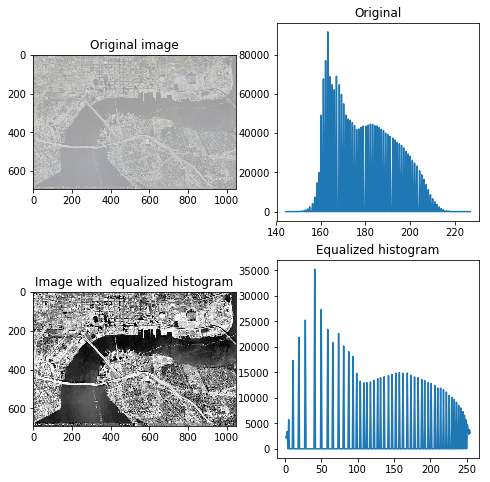

In [62]:
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img_name, cmap=cm.gray)
ax0.set_title('Original image')

bins, bins_c=np.histogram(img_name, 256)
ax1.plot(bins_c[1:], bins)
ax1.set_title('Original')

ax2.imshow(sat_eq, cmap=cm.gray)
ax2.set_title('Image with  equalized histogram')

bins, bins_c=np.histogram(sat_eq, 256)
ax3.plot(bins_c[1:], bins)
ax3.set_title('Equalized histogram')


### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

In [39]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [40]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

In [42]:
from scipy.stats import norm

max_img=np.amax(img_name_ubyte)
x = np.arange(256)
pdf_to_fit = norm.pdf(x, 150, 30)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

81


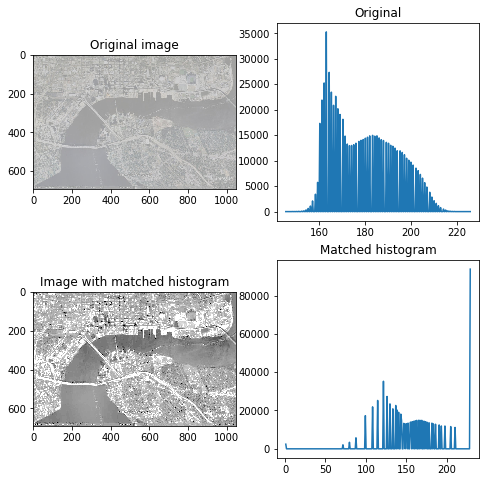

In [63]:
sat_matched=hist_match(img_name_ubyte, pdf_to_fit, img_name_ubyte.min(), img_name_ubyte.max())
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img_name, cmap=cm.gray)
ax0.set_title('Original image')

bins, bins_c=np.histogram(img_name_ubyte, 256)
ax1.plot(bins_c[1:], bins)
ax1.set_title('Original')

ax2.imshow(sat_matched, cmap=cm.gray)
ax2.set_title('Image with matched histogram')

bins, bins_c=np.histogram(sat_matched, 256)
ax3.plot(bins_c[1:], bins)
ax3.set_title('Matched histogram')

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


** Explain how sigmoid function enhances the image **